Imports

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers, callbacks, optimizers, Sequential
import tensorflow as tf
from tensorflow import keras

Download

In [4]:
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-12-31"
df = yf.download(ticker, start=start_date, end=end_date, progress=False)

/tmp/ipython-input-3446205011.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


cleaning & checks

In [5]:
df = df.reset_index().rename(columns=str.title)   # ensure Date column present, title-case cols
df = df.sort_values("Date")
# Keep only what we’ll model first (Close). We’ll add more features later if needed.
df = df[["Date", "Close"]].dropna()
df["Close"] = df["Close"].astype("float64")

print("Rows:", len(df))
print(df.head(3))
print(df.tail(3))
print(df.isna().sum())

Rows: 1257
Price        Date      Close
Ticker                  Aapl
0      2020-01-02  72.538528
1      2020-01-03  71.833298
2      2020-01-06  72.405670
Price        Date       Close
Ticker                   Aapl
1254   2024-12-26  258.103729
1255   2024-12-27  254.685867
1256   2024-12-30  251.307861
Price  Ticker
Date             0
Close  Aapl      0
dtype: int64


visual sanity check

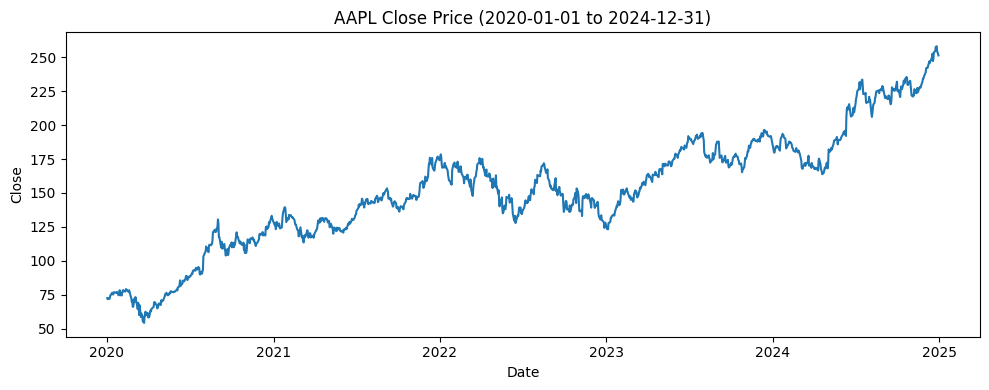

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["Close"])
plt.title(f"{ticker} Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()


Save a frozen copy for reproducibility

In [7]:
csv_path = f"{ticker}_{start_date}_{end_date}.csv"
df.to_csv(csv_path, index=False)
print("Saved to:", csv_path)

Saved to: AAPL_2020-01-01_2024-12-31.csv


# Feedforward baseline

Windowing utilities + time-aware split + scaling

In [10]:
LOOKBACK = 30     # number of past days to use as features
TEST_RATIO = 0.15 # last 15% of the series as test
VAL_RATIO  = 0.15 # slice from the end of the *train* part

Helpers

In [14]:
def make_windows(series: np.ndarray, lookback: int):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i])
        y.append(series[i])
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    return X, y

Extract numpy array

In [16]:
close = df["Close"].values.astype("float32")

# 2) Time-aware split indices
n = len(close)
n_test = int(np.ceil(n * TEST_RATIO))
n_trainval = n - n_test

train/val split

In [17]:
n_val = int(np.ceil(n_trainval * VAL_RATIO))
n_train = n_trainval - n_val

train_series   = close[:n_train]
val_series     = close[n_train:n_trainval]
test_series    = close[n_trainval:]

print(f"Lengths -> train:{len(train_series)}, val:{len(val_series)}, test:{len(test_series)}")

Lengths -> train:907, val:161, test:189


Scale using only training data

In [18]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.reshape(-1,1)).ravel()
val_scaled   = scaler.transform(val_series.reshape(-1,1)).ravel()
test_scaled  = scaler.transform(test_series.reshape(-1,1)).ravel()

Make windows for each split

In [19]:
X_train, y_train = make_windows(train_scaled, LOOKBACK)
X_val,   y_val   = make_windows(np.concatenate([train_scaled[-LOOKBACK:], val_scaled]), LOOKBACK)
X_test,  y_test  = make_windows(np.concatenate([np.concatenate([train_scaled, val_scaled])[-LOOKBACK:], test_scaled]), LOOKBACK)

In [20]:
print("Shapes:")
print(" X_train:", X_train.shape, " y_train:", y_train.shape)
print(" X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print(" X_test: ", X_test.shape,  " y_test: ", y_test.shape)

Shapes:
 X_train: (877, 30)  y_train: (877,)
 X_val:   (161, 30)  y_val:   (161,)
 X_test:  (189, 30)  y_test:  (189,)


# Build & train a simple MLP (feedforward)

In [23]:
tf.random.set_seed(7)
np.random.seed(7)

In [24]:
def build_mlp(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # linear output for regression
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="mae",  # optimize MAE directly
                  metrics=["mae"])
    return model

In [25]:
mlp = build_mlp(LOOKBACK)
mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,209 (24.25 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_mae")
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print("Best val MAE:", np.min(history.history["val_mae"]))

Best val MAE: 0.015389279462397099


Evaluate on test set

In [27]:
y_pred_test_scaled = mlp.predict(X_test).ravel()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [28]:
def inverse(x_scaled):
    return scaler.inverse_transform(x_scaled.reshape(-1,1)).ravel()

y_test_price = inverse(y_test)
y_pred_price = inverse(y_pred_test_scaled)

test_mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test MAE (MLP, lookback={LOOKBACK}): {test_mae:.3f} USD")

Test MAE (MLP, lookback=30): 2.711 USD


Build a time axis

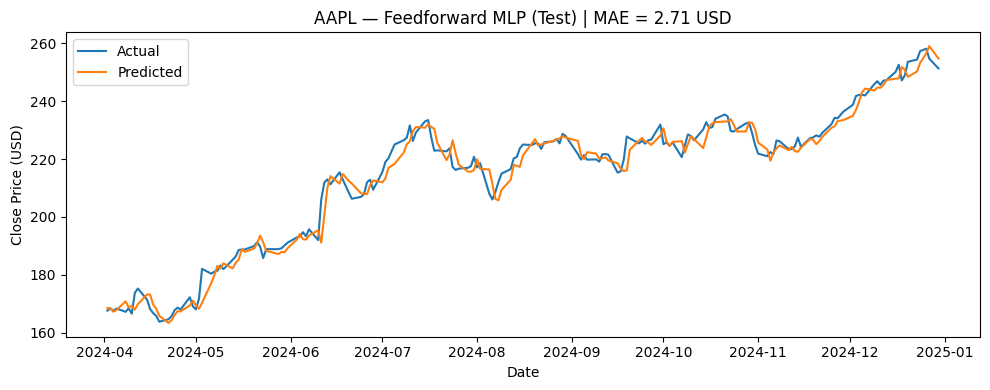

In [29]:
test_target_start_idx = len(df) - len(y_test_price)
test_dates = df["Date"].iloc[test_target_start_idx:].reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_price, label="Actual")
plt.plot(test_dates, y_pred_price, label="Predicted")
plt.title(f"AAPL — Feedforward MLP (Test) | MAE = {test_mae:.2f} USD")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

LSTM (sequence model with memory)

In [30]:
def make_seq(series_scaled: np.ndarray, lookback: int):
    """Return X (n, lookback, 1), y (n,) from a 1D scaled series."""
    X, y = [], []
    for i in range(lookback, len(series_scaled)):
        X.append(series_scaled[i - lookback:i].reshape(lookback, 1))
        y.append(series_scaled[i])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [31]:
Xtr2d, ytr = make_seq(train_scaled, LOOKBACK)

val_concat = np.concatenate([train_scaled[-LOOKBACK:], val_scaled])
Xval2d, yval = make_seq(val_concat, LOOKBACK)

test_concat = np.concatenate([np.concatenate([train_scaled, val_scaled])[-LOOKBACK:], test_scaled])
Xte2d, yte = make_seq(test_concat, LOOKBACK)

In [32]:
print("LSTM shapes:")
print(" X_train:", Xtr2d.shape, " y_train:", ytr.shape)
print(" X_val:  ", Xval2d.shape, " y_val:  ", yval.shape)
print(" X_test: ", Xte2d.shape, " y_test: ", yte.shape)

LSTM shapes:
 X_train: (877, 30, 1)  y_train: (877,)
 X_val:   (161, 30, 1)  y_val:   (161,)
 X_test:  (189, 30, 1)  y_test:  (189,)


Build & train the LSTM

In [33]:
tf.random.set_seed(7)
np.random.seed(7)

def build_lstm(lookback: int, units: int = 64, dropout: float = 0.2):
    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1)  # linear output
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="mae",
                  metrics=["mae"])
    return model

In [34]:
lstm = build_lstm(LOOKBACK, units=64, dropout=0.2)
lstm.summary()

es = callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
history_lstm = lstm.fit(
    Xtr2d, ytr,
    validation_data=(Xval2d, yval),
    epochs=200,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print("Best LSTM val MAE:", np.min(history_lstm.history["val_mae"]))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Best LSTM val MAE: 0.020512109622359276


Evaluate on test set

In [35]:
ypred_te_scaled = lstm.predict(Xte2d).ravel()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [36]:
def inverse(x_scaled):
    return scaler.inverse_transform(x_scaled.reshape(-1,1)).ravel()

y_test_price = inverse(yte)
y_pred_price = inverse(ypred_te_scaled)

test_mae_lstm = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test MAE (LSTM, lookback={LOOKBACK}): {test_mae_lstm:.3f} USD")

Test MAE (LSTM, lookback=30): 4.121 USD


Build date index for the test targets

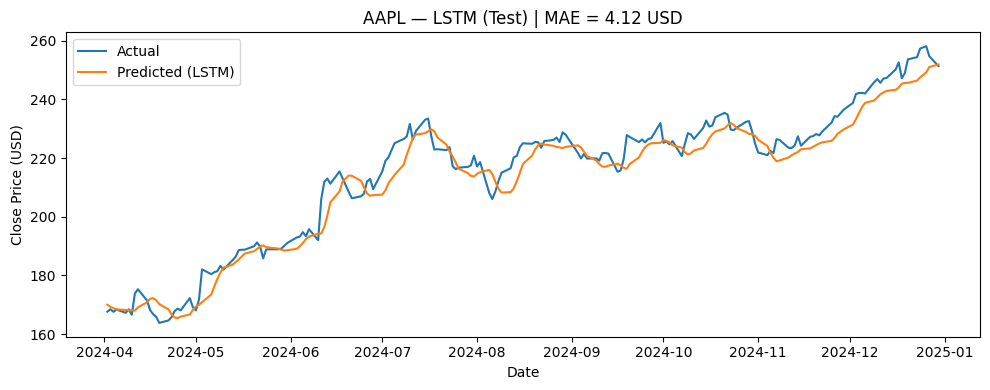

In [37]:
test_target_start_idx = len(df) - len(y_test_price)
test_dates = df["Date"].iloc[test_target_start_idx:].reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_price, label="Actual")
plt.plot(test_dates, y_pred_price, label="Predicted (LSTM)")
plt.title(f"AAPL — LSTM (Test) | MAE = {test_mae_lstm:.2f} USD")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

Train a GRU model

In [44]:
def build_gru(lookback: int, units: int = 64, dropout: float = 0.2):
    model = Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.GRU(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss="mae",
                  metrics=["mae"])
    return model

In [47]:
gru = build_gru(LOOKBACK, units=64, dropout=0.2)
gru.summary()

es = callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
history_gru = gru.fit(
    Xtr2d, ytr,
    validation_data=(Xval2d, yval),
    epochs=200,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print("Best GRU val MAE:", np.min(history_gru.history["val_mae"]))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Best GRU val MAE: 0.014904187992215157


Evaluate & plot

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Test MAE (GRU, lookback=30): 3.415 USD


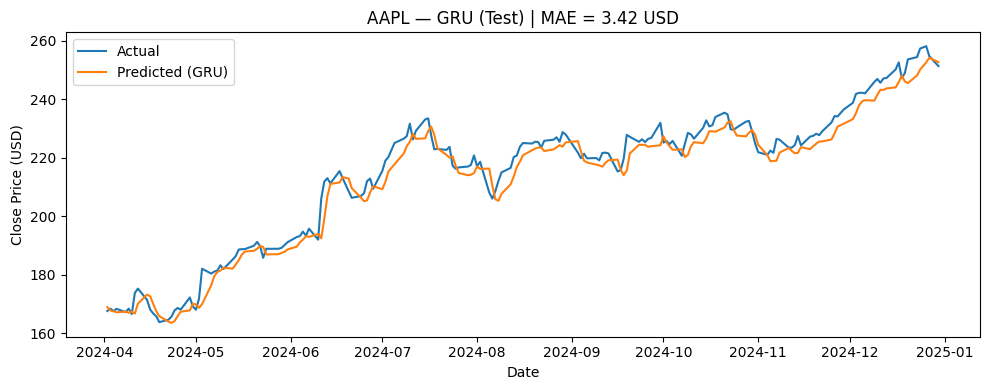

In [48]:
y_pred_gru_scaled = gru.predict(Xte2d).ravel()

y_pred_gru_price = inverse(y_pred_gru_scaled)
gru_mae = mean_absolute_error(y_test_price, y_pred_gru_price)
print(f"Test MAE (GRU, lookback={LOOKBACK}): {gru_mae:.3f} USD")

plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test_price, label="Actual")
plt.plot(test_dates, y_pred_gru_price, label="Predicted (GRU)")
plt.title(f"AAPL — GRU (Test) | MAE = {gru_mae:.2f} USD")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

Compare all models

In [50]:
# Model comparison summary
comparison = pd.DataFrame({
    "Model": ["Feedforward MLP", "LSTM", "GRU"],
    "Test MAE (USD)": [test_mae, test_mae_lstm, gru_mae]
})
print(comparison)


             Model  Test MAE (USD)
0  Feedforward MLP        2.710518
1             LSTM        4.121428
2              GRU        3.415270


| Model    | Key Trait                   | When It Helps                                    |
| :------- | :-------------------------- | :----------------------------------------------- |
| **MLP**  | Static, no memory           | Baseline trend fitting                           |
| **LSTM** | Long memory via cell states | Captures multi-day dependencies                  |
| **GRU**  | Simpler memory gates        | Often equal or better accuracy with fewer params |
